### przewidywanie liczby na kostce

Wybrałam zmieszanie podejścia optymalizacyjnego z konceptualnym. Stworzyłam jeden podstawowy model, który jest sukcesywnie dostosowywany i testowany. Dostosowywałam strukturę modelu (warstwy konwolucyjne) oraz hiperparametry (learning rate). Dodałam upsampling SMOTE. Wybór struktury sieci (tj. używanie CNN i poolingu do przetwarzania obrazów) oparłam na ustalonych praktykach klasyfikacji obrazów (jest to standard, który jest sukcesywnie rozwijany – np. Yim, J., Ju, J., Jung, H., Kim, J. (2015). Image Classification Using Convolu-tional Neural Networks With Multi-stage Feature). 
* Zastosowałam optymalizator Adam, ponieważ automatycznie dostosowuje współczynniki uczenia się dla różnych parametrów, łączy zalety dwóch rozszerzeń stochastycznego spadku gradientu, a także jest bardziej wydajny i wymaga mniej strojenia hiperparametrów.
* Zastosowałam funkcję aktywacji ReLU, ponieważ pomaga w rozwiązywaniu problemu zanikającego gradientu, który często występuje w sieciach neuronowych z sigmoidalnymi lub tanh funkcjami aktywacji. Jest obliczeniowo mniej złożona niż inne funkcje aktywacji bo wymaga tylko porównania z zerem.
* Zastosowałam entropię krzyżową jako funkcję straty, bo jest standardem w zadaniach klasyfikacyjnych zwłaszcza gdy wyjścia są interpretowane jako prawdopodobieństwa.
* Jako miary jakości modelu użyłam głównie dokładności, a także precyzji (nie chcemy fałszywych pozytywów), czułości (ani fałszywych negatywów) i skali F1 (i czułość i precyzja ma pewne znaczenie).
* Użyłam upsamplingu SMOTE który tworzy syntetyczne próbki, żeby zwiększyć ilość danych, co przeciwdziała overfittingowi (mimo iż klasy są równe, w dalszym ciągu zwiększa ilość danych, co przy podziale na trzy zbiory miało znaczenie i sprawiło, że wynik się po-prawił).
* Czego próbowałam użyć – Dropoutu (który ogólnie jest niezłą metodą regularyzacji dla większych zbiorów danych), w celu zwiększenia dokładności, jednak pogorszyła się zarówno treningowa jak i walidacyjna, więc z niego zrezygnowałam.
* Zrobiłam tuning liczby warstw konwolucyjnych, liczby epok (zwiększałam i zmniejszałam), a także learning rate.


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim
from sklearn.model_selection import train_test_split

file_path = '/Users/chostenko/Desktop/PBŚ/VI semestr/Sieci neuronowe/PROJ/ssn2024/dice.csv'
data = pd.read_csv(file_path)

print("dane dice")
print(data.head())

# oddzielenie etykiet od obrazów
labels = torch.tensor(data.iloc[:, 0].values) - 1  # etykiety od 0 do 5 bo tak jest na kostce
images = torch.tensor(data.iloc[:, 1:].values).float()
images = images.reshape(-1, 1, 28, 28) / 255.0  # normalizacja i zmiana kształtu

# podzial na treningowy, walidacyjny i testowy
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42  # 20% danych na testy
)
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.25, random_state=42  # 20% danych treningowych na walidację
)

# dataloadery
train_dataset = TensorDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(val_images, val_labels)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

test_dataset = TensorDataset(test_images, test_labels)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# definicja modelu - cnn + relu 
class DiceClassifier(nn.Module):
    def __init__(self):
        super(DiceClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(64 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, 6)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = DiceClassifier()
criterion = nn.CrossEntropyLoss()
#adam bo powinien optymalizowac hiperparametry
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / total
    train_accuracy = 100 * correct / total
    
    # walidacja 
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_loss /= val_total
    val_accuracy = 100 * val_correct / val_total

    print(f'Epoka {epoch+1}, Strata treningowa {train_loss:.4f}, Dokładność treningowa {train_accuracy:.2f}%, Strata walidacyjna {val_loss:.4f}, Dokładność walidacyjna {val_accuracy:.2f}%')

# ewaluacja na zbiorze testowym
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Dokładność na zbiorze testowym {test_accuracy:.2f}%')


dane dice
   1  246  246.1  246.2  246.3  246.4  246.5  246.6  246.7  246.8  ...  \
0  1  140    140    140    140    140    140    140    140    140  ...   
1  1  124    124    124    124    124    124    124    124    124  ...   
2  1  217    217    217    217    217    217    217    217    217  ...   
3  1  104    104    104    104    104    104    104    104    104  ...   
4  1   54     54     54     54     54     54     54     54     54  ...   

   246.551  246.552  246.553  246.554  246.555  246.556  246.557  246.558  \
0      140      140      140      140      140      140      140      140   
1      124      124      124      124      124      124      124      124   
2      217      217      217      217      217      217      217      217   
3      104      104      104      104      104      104      104      104   
4       54       54       54       54       54       54       54       54   

   246.559  246.560  
0      140      140  
1      124      124  
2      217      

In [4]:
print(f'Dokładność modelu na zbiorze walidacyjnym {val_accuracy:.2f}%')

Dokładność modelu na zbiorze walidacyjnym: 95.36%


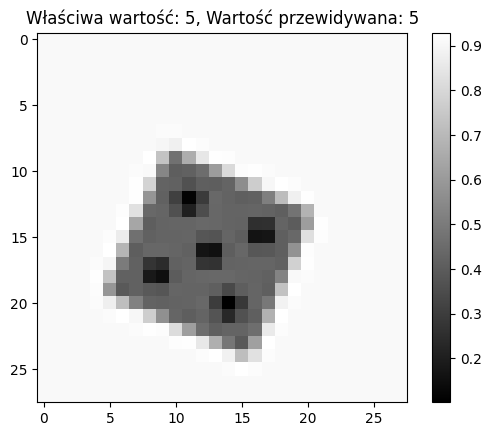

In [7]:
def display_prediction(test_loader, model):
    model.eval()  # tryb ewaluacji
    images, labels = next(iter(test_loader))  # pobranie batcha z dataloader
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    # wybor losowego obrazu z batcha
    idx = torch.randint(0, images.size(0), (1,)).item()
    img = images[idx].squeeze()  # usunięcie zbędnych wymiarów
    actual_label = labels[idx].item() + 1  # prawdziwa wartość, 1 trzeba dodac bo label było 0-5
    predicted_label = predicted[idx].item() + 1  # przewidywana wartość

    plt.imshow(img, cmap='gray')
    plt.colorbar()
    plt.title(f"Właściwa wartość {actual_label}, Wartość przewidywana {predicted_label}")
    plt.show()

display_prediction(test_loader, model)


In [8]:
from sklearn.metrics import f1_score, precision_score, recall_score

# ewaluacja na zbiorze testowym
model.eval()
test_correct = 0
test_total = 0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        predicted_labels.extend(predicted.numpy())
        true_labels.extend(labels.numpy())

test_accuracy = 100 * test_correct / test_total
print(f'Dokładność modelu na zbiorze testowym {test_accuracy:.2f}%')

# Obliczanie dodatkowych metryk
f1 = f1_score(true_labels, predicted_labels, average='weighted')
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')

print(f'F1 score {f1:.4f}, Precyzja {precision:.4f}, Czułość {recall:.4f}')


Dokładność modelu na zbiorze testowym: 95.07%
F1 score: 0.9507, Precyzja: 0.9519, Czułość: 0.9507


Dokładność modelu na zbiorze testowym: 95.07%
Macierz pomyłek:
[[1993   11    0    0    0    0]
 [   0 1946   18    5    0    0]
 [   0    7 1853   54   24    2]
 [   0    1   12 1876    3  152]
 [   0    0    4    4 1983   39]
 [   0    0    1   20  235 1757]]


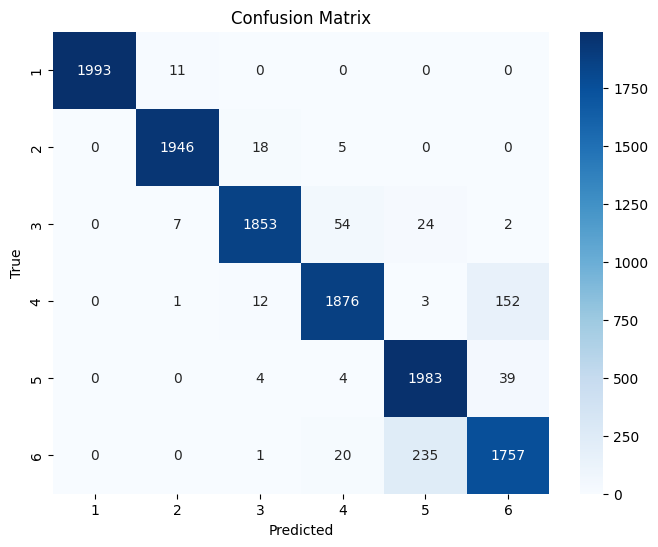

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# ewaluacja na zbiorze testowym
model.eval()
test_correct = 0
test_total = 0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        predicted_labels.extend(predicted.numpy())
        true_labels.extend(labels.numpy())

test_accuracy = 100 * test_correct / test_total
print(f'Dokładność modelu na zbiorze testowym {test_accuracy:.2f}%')

# Obliczanie macierzy pomyłek
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Macierz pomyłek")
print(conf_matrix)

# Wizualizacja macierzy pomyłek
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(1, 7), yticklabels=np.arange(1, 7))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()


SMOTE, dropout, zmiana liczby warstw konwolucyjnych, learning rate

Epoka 1, Strata treningowa: 1.1926, Dokładność treningowa: 45.49%, Strata walidacyjna: 0.9262, Dokładność walidacyjna: 55.43%
Epoka 2, Strata treningowa: 0.5385, Dokładność treningowa: 77.24%, Strata walidacyjna: 0.3054, Dokładność walidacyjna: 88.65%
Epoka 3, Strata treningowa: 0.1990, Dokładność treningowa: 93.46%, Strata walidacyjna: 0.1619, Dokładność walidacyjna: 94.90%
Epoka 4, Strata treningowa: 0.0885, Dokładność treningowa: 97.37%, Strata walidacyjna: 0.0498, Dokładność walidacyjna: 98.92%
Epoka 5, Strata treningowa: 0.0404, Dokładność treningowa: 98.94%, Strata walidacyjna: 0.0306, Dokładność walidacyjna: 99.18%
Dokładność modelu na zbiorze testowym: 99.22%


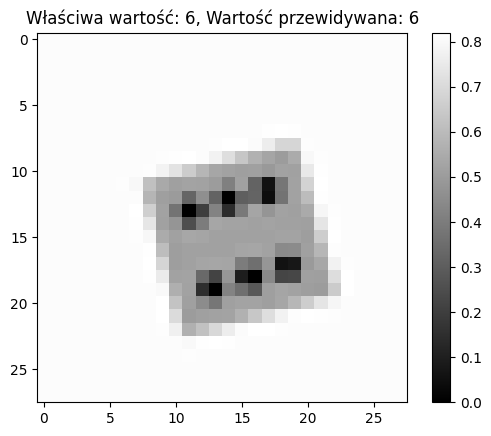

Dokładność modelu na zbiorze testowym: 99.22%
F1 score: 0.9922, Precyzja: 0.9922, Czułość: 0.9922
Macierz pomyłek:
[[2004    0    0    0    0    0]
 [   3 1966    0    0    0    0]
 [   0    2 1937    1    0    0]
 [   0    2   11 2021    0   10]
 [   0    0    6    0 2012   12]
 [   0    0    7   14   26 1966]]


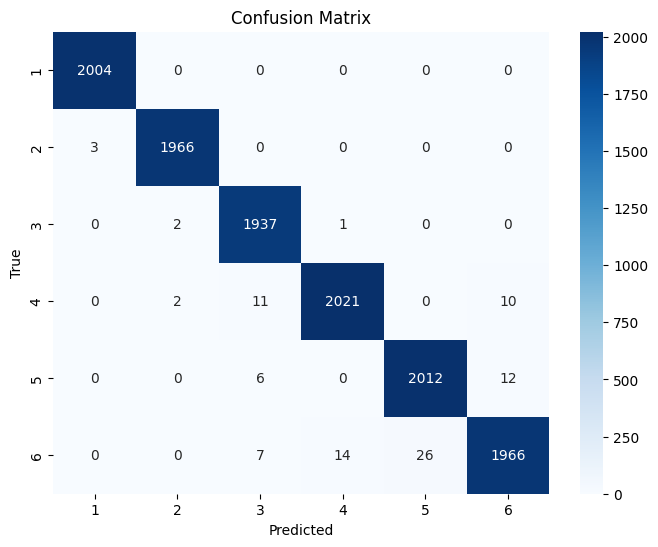

In [10]:
import torch
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

# Wczytanie danych
file_path = '/Users/chostenko/Desktop/PBŚ/VI semestr/Sieci neuronowe/PROJ/ssn2024/dice.csv'
data = pd.read_csv(file_path)

# Oddzielenie etykiet od obrazów
labels = torch.tensor(data.iloc[:, 0].values) - 1  # etykiety od 0 do 5 bo tak jest na kostce
images = torch.tensor(data.iloc[:, 1:].values).float()
images = images.reshape(-1, 1, 28, 28) / 255.0  # normalizacja i zmiana kształtu

# Podział na treningowy, walidacyjny i testowy
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42  # 20% danych na testy
)
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.25, random_state=42  # 20% danych treningowych na walidację
)

# Dataloaders
train_dataset = TensorDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(val_images, val_labels)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

test_dataset = TensorDataset(test_images, test_labels)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# definicja modelu cnn+relu
class DiceClassifier(nn.Module):
    def __init__(self):
        super(DiceClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(64 * 7 * 7, 64)  
        self.fc2 = nn.Linear(64, 6)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# inicjalizacja
model = DiceClassifier()

# definicja funkcji straty i optymalizatora
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  

# definicja liczby epok
num_epochs = 5

# petla treningowa
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / total
    train_accuracy = 100 * correct / total
    
    # walidacja 
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_loss /= val_total
    val_accuracy = 100 * val_correct / val_total

    print(f'Epoka {epoch+1}, Strata treningowa {train_loss:.4f}, Dokładność treningowa {train_accuracy:.2f}%, Strata walidacyjna {val_loss:.4f}, Dokładność walidacyjna {val_accuracy:.2f}%')

# ewaluacja na zbiorze testowym
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Dokładność modelu na zbiorze testowym {test_accuracy:.2f}%')

def display_prediction(test_loader, model):
    model.eval()  
    images, labels = next(iter(test_loader))  
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    idx = torch.randint(0, images.size(0), (1,)).item()
    img = images[idx].squeeze()  
    actual_label = labels[idx].item() + 1  
    predicted_label = predicted[idx].item() + 1  

    plt.imshow(img, cmap='gray')
    plt.colorbar()
    plt.title(f"Właściwa wartość {actual_label}, Wartość przewidywana {predicted_label}")
    plt.show()

display_prediction(test_loader, model)


model.eval()
test_correct = 0
test_total = 0
predicted_labels = []
true_labels = []

#dokładność
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        predicted_labels.extend(predicted.numpy())
        true_labels.extend(labels.numpy())

test_accuracy = 100 * test_correct / test_total
print(f'Dokładność modelu na zbiorze testowym {test_accuracy:.2f}%')

# dodatkowe metryki
f1 = f1_score(true_labels, predicted_labels, average='weighted')
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')

print(f'F1 score {f1:.4f}, Precyzja {precision:.4f}, Czułość {recall:.4f}')

# macierz pomyłek
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Macierz pomyłek:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(1, 7), yticklabels=np.arange(1, 7))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()


In [11]:
print(f'Dokładność modelu na zbiorze walidacyjnym {val_accuracy:.2f}%')

Dokładność modelu na zbiorze walidacyjnym: 99.18%


In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim
from sklearn.model_selection import train_test_split

file_path = '/Users/chostenko/Desktop/PBŚ/VI semestr/Sieci neuronowe/PROJ/ssn2024/dice.csv'
data = pd.read_csv(file_path)

print("dane dice")
print(data.head())

# oddzielenie etykiet od obrazów
labels = torch.tensor(data.iloc[:, 0].values) - 1  # etykiety od 0 do 5 bo tak jest na kostce
images = torch.tensor(data.iloc[:, 1:].values).float()
images = images.reshape(-1, 1, 28, 28) / 255.0  # normalizacja i zmiana kształtu

# podział na treningowy, walidacyjny i testowy
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42  # 20% danych na testy
)
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.25, random_state=42  # 20% danych treningowych na walidację
)

# dataloadery
train_dataset = TensorDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(val_images, val_labels)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

test_dataset = TensorDataset(test_images, test_labels)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# definicja modelu z dodatkiem dropout
class DiceClassifier(nn.Module):
    def __init__(self):
        super(DiceClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # dropout z prawdopodobieństwem 0.5
        self.fc1 = nn.Linear(64 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, 6)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.relu(self.dropout(self.conv3(x)))  #dropout na warstwie konwolucyjnej
        x = torch.flatten(x, 1)
        x = self.relu(self.dropout(self.fc1(x)))  # dropout na pierwszej warstwie fc
        x = self.fc2(x)
        return x

model = DiceClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / total
    train_accuracy = 100 * correct / total
    
    # walidacja 
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_loss /= val_total
    val_accuracy = 100 * val_correct / val_total

    print(f'Epoka {epoch+1}, Strata treningowa {train_loss:.4f}, Dokładność treningowa {train_accuracy:.2f}%, Strata walidacyjna {val_loss:.4f}, Dokładność walidacyjna {val_accuracy:.2f}%')

# ewaluacja na zbiorze testowym
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Dokładność na zbiorze testowym {test_accuracy:.2f}%')


dane dice
   1  246  246.1  246.2  246.3  246.4  246.5  246.6  246.7  246.8  ...  \
0  1  140    140    140    140    140    140    140    140    140  ...   
1  1  124    124    124    124    124    124    124    124    124  ...   
2  1  217    217    217    217    217    217    217    217    217  ...   
3  1  104    104    104    104    104    104    104    104    104  ...   
4  1   54     54     54     54     54     54     54     54     54  ...   

   246.551  246.552  246.553  246.554  246.555  246.556  246.557  246.558  \
0      140      140      140      140      140      140      140      140   
1      124      124      124      124      124      124      124      124   
2      217      217      217      217      217      217      217      217   
3      104      104      104      104      104      104      104      104   
4       54       54       54       54       54       54       54       54   

   246.559  246.560  
0      140      140  
1      124      124  
2      217      